In [13]:
import os
import numpy as np
import pandas as pd
import argparse  
import sampler_functions as sf
import analysis as an
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
params = {
    'm': 10,
    'k': 2,
    'mu_true': 10.0,
    'prior_mean': 0.0,
    'prior_std': 20.0,
    'num_iterations_T': 30000,
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.07
}

# Generate the initial "observed" data and its MLE
x_original, mu_star = sf.generate_initial_data(params)
params['mu_star'] = mu_star

# Add z_domain to params, as it depends on k
z_domain_half_width = 1 / (2 * np.sqrt(params['k']))
params['z_domain'] = (-z_domain_half_width, z_domain_half_width)

# Initialize the sampler's starting state
mu_0, x_0 = sf.initialize_sampler(params)

print(f"Setup complete. Observed μ* = {mu_star:.4f}")


--- Generating initial data and finding MLE (μ*) ---
Generated 10 data points with true μ = 10.0.
Calculated MLE μ* = 9.9581
--- Initializing sampler state ---
Setup complete. Observed μ* = 9.9581


In [5]:
mle_samples = sf.compute_benchmark_mle_samples(params, num_simulations=50000)
kde_0 = stats.gaussian_kde(mle_samples)


# Run the main Insufficient Gibbs Sampler to get p(μ|μ*)
gibbs_results = sf.run_main_gibbs_sampler(params, mu_0, x_0)
mu_chain_mle = gibbs_results['mu_chain']

# Run a separate, simple MCMC to get the "gold standard" posterior p(μ|x)
mu_chain_full_data = sf.run_full_data_sampler(params, x_original, mu_0)

# Generate the two sets of posterior predictive samples for x
x_pred_mle_flat, x_pred_full_data_flat = sf.generate_all_predictive_samples(
    mu_chain_mle, mu_chain_full_data, params
)



--- Computing Benchmark KDE from 50000 simulations ---
(This is computationally intensive and will take some time...)
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Benchmark MLE samples computed successfully.

--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 29999/29999 [01:19<00:00, 376.53it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4348
Z_i Acceptance Rate: 0.6372

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5915.62it/s]


Full-data posterior sampling complete.

--- Generating Posterior Predictive Datasets ---
Generating 10000 samples from p(x|μ*)...


Sampling x|μ*: 100%|██████████| 10000/10000 [00:00<00:00, 66499.94it/s]


Generating 10000 samples from p(x|x_original)...


Sampling x|x: 100%|██████████| 10000/10000 [00:00<00:00, 67228.26it/s]


In [ ]:
def plot_posterior_comparison(mle_chain, x_original, params, filename=None):
    """
    Compares the sampler's posterior p(μ|μ*) against the true analytical
    posterior from the full data, p(μ|x).

    Args:
        mle_chain (np.array): The MCMC chain for μ from the Gibbs sampler.
        x_original (np.array): The original, full dataset.
        params (dict): The parameters dictionary.
        filename (str, optional): Path to save the plot.
    """
    print("\n--- Generating Final Posterior Comparison Plot (Sampler vs. True Analytical) ---")
    
    # --- 1. Get the samples from the Gibbs sampler (for p(μ|μ*)) ---
    burn_in = int(len(mle_chain) * 0.2)
    posterior_mle_samples = mle_chain[burn_in:]

    # --- 2. Calculate the True Analytical Posterior p(μ|x) ---
    mu_grid = np.linspace(posterior_mle_samples.min() - 1, posterior_mle_samples.max() + 1, 500)
    
    # Calculate the unnormalized posterior using our log_posterior_mu function
    log_posterior_vals = [sf.log_posterior_mu(mu, x_original, params['k'], params['prior_mean'], params['prior_std']) for mu in mu_grid]
    unnormalized_posterior_full = np.exp(log_posterior_vals - np.max(log_posterior_vals)) # Subtract max for stability


    # Normalize using numerical integration
    # integral_area = np.trapezoid(unnormalized_posterior_full, mu_grid)
    integral_area = np.trapz(unnormalized_posterior_full, mu_grid)
    true_posterior_full_data = unnormalized_posterior_full / integral_area

    # --- 3. Quantitative Comparison ---
    mean_mle = np.mean(posterior_mle_samples)
    std_mle = np.std(posterior_mle_samples)
    # mean_full = np.trapezoid(mu_grid * true_posterior_full_data, mu_grid)
    # std_full = np.sqrt(np.trapezoid((mu_grid - mean_full)**2 * true_posterior_full_data, mu_grid))
    mean_full = np.trapz(mu_grid * true_posterior_full_data, mu_grid)
    std_full = np.sqrt(np.trapz((mu_grid - mean_full)**2 * true_posterior_full_data, mu_grid))


    print(f"Posterior from MLE only (Sampler): Mean = {mean_mle:.4f}, Std Dev = {std_mle:.4f}")
    print(f"Posterior from Full Data (True):   Mean = {mean_full:.4f}, Std Dev = {std_full:.4f}")

    # --- 4. Visual Comparison ---
    plt.figure(figsize=(12, 8))
    
    # Plot the KDE of our Gibbs sampler's output
    kde_mle = stats.gaussian_kde(posterior_mle_samples)
    plt.plot(mu_grid, kde_mle(mu_grid), color='red', lw=2.5, label=f"p(μ | μ*) - Sampler Output [Std Dev = {std_mle:.3f}]")
    plt.fill_between(mu_grid, kde_mle(mu_grid), color='red', alpha=0.2)

    # Plot the true analytical posterior curve
    plt.plot(mu_grid, true_posterior_full_data, color='blue', lw=2.5, label=f"p(μ | x) - True Posterior [Std Dev = {std_full:.3f}]")
    plt.fill_between(mu_grid, true_posterior_full_data, color='blue', alpha=0.2)

    # Reference lines
    plt.axvline(params['mu_true'], color='black', linestyle='--', linewidth=2, label=f"True μ")
    plt.axvline(params['mu_star'], color='darkorange', linestyle=':', linewidth=2.5, label=f"Observed MLE (μ*)")
    plt.title("Comparison of Posteriors: Full Data vs. MLE Only", fontsize=16)
    plt.xlabel("Value of μ")
    plt.ylabel("Posterior Density")
    plt.legend(fontsize=12)
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename}")
        plt.close()
    else:
        plt.show()



--- Generating Consolidated Diagnostic and Validation Plot ---


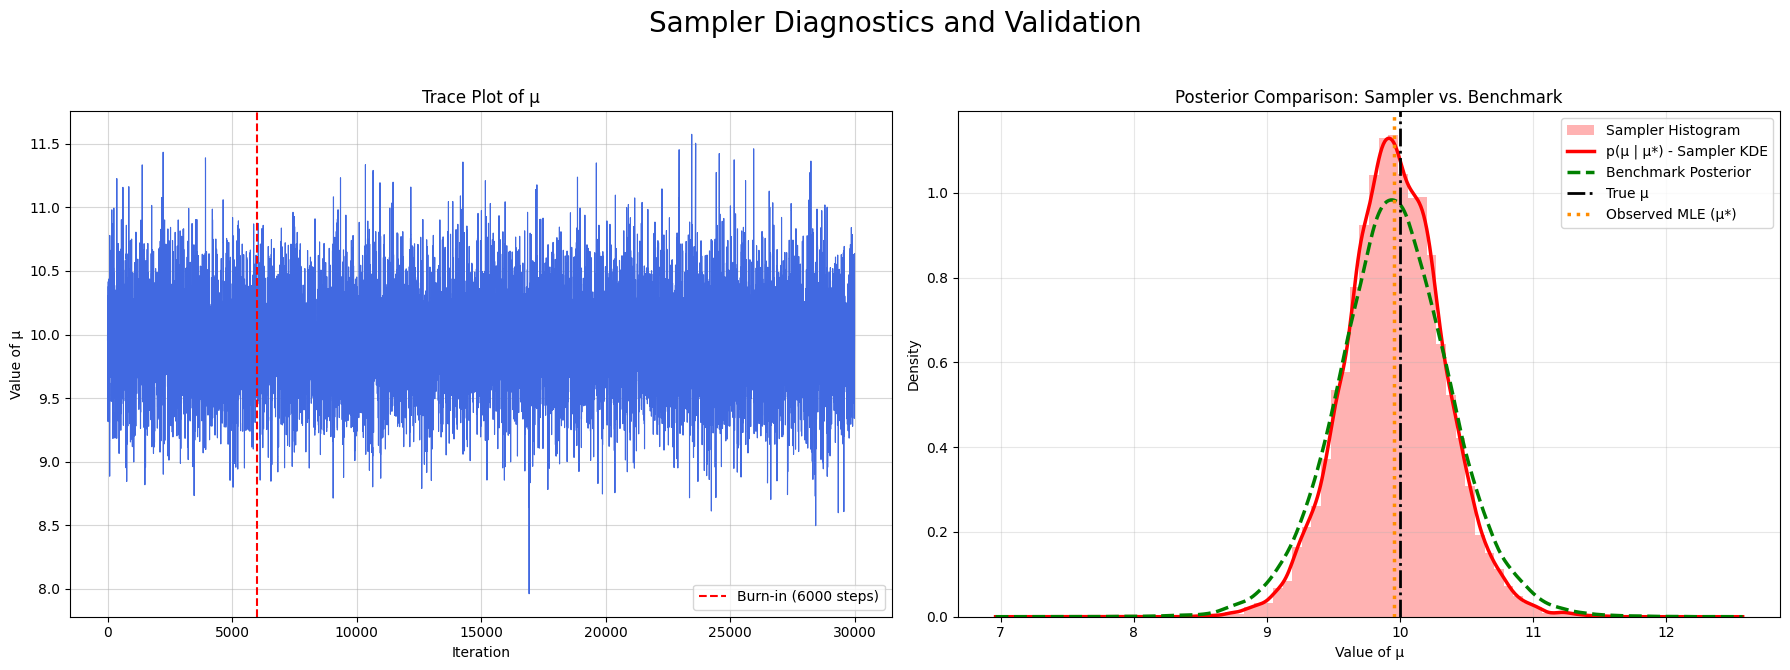

In [9]:
an.plot_diagnostics_with_benchmark(
    results=gibbs_results,
    params=params,
    kde_0=kde_0, # Pass the computed KDE object
    filename=None
)


--- Generating Final Posterior Comparison Plot (Sampler vs. True Analytical) ---
Posterior from MLE only (Sampler): Mean = 9.9581, Std Dev = 0.3699
Posterior from Full Data (True):   Mean = 9.9387, Std Dev = 0.3952


/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_55486/378034507.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_area = np.trapz(unnormalized_posterior_full, mu_grid)
/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_55486/378034507.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_full = np.trapz(mu_grid * true_posterior_full_data, mu_grid)
/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_55486/378034507.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  std_full = np.sqrt(np.trapz((mu_grid - mean_full)**2 * true_posterior_full_data, mu_grid))


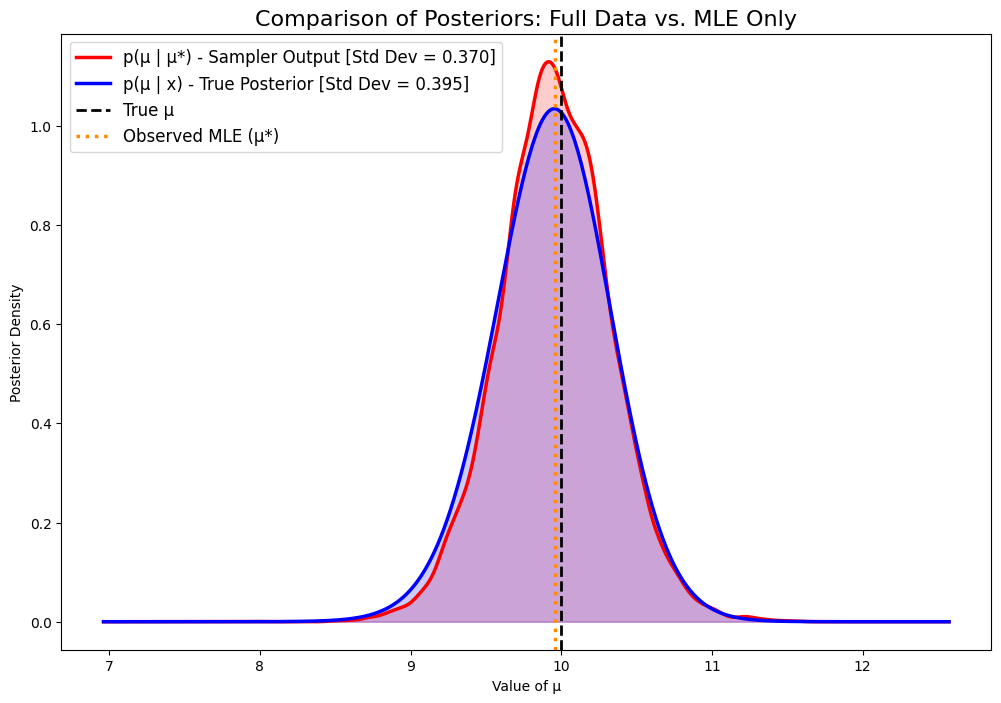

In [10]:
# Generate the posterior comparison plot (Experiment 1)
plot_posterior_comparison(
    mle_chain=mu_chain_mle, 
    x_original=x_original, 
    params=params, 
    filename=None
)


In [11]:
def plot_single_run_posterior_validation(x_original, mu_chain_mle, kde_0, sf, params, save_path=None):
    """
    Creates a single plot comparing three posteriors for one dataset:
    1. Benchmark posterior p(μ|μ̂) calculated from a pre-computed KDE.
    2. Sampler posterior p(μ|μ̂) from a Gibbs sampler chain.
    3. True analytical posterior p(μ|x) from the full data.

    Args:
        x_original (np.array): The dataset being analyzed.
        mu_chain_mle (np.array): The MCMC chain for μ from the Gibbs sampler.
        kde_0 (scipy.stats.gaussian_kde): The pre-computed benchmark KDE object.
        sf (module): Your sampler_functions module.
        params (dict): The experiment parameters dictionary.
        save_path (str, optional): Path to save the figure. If None, shows the plot.
    """
    print("\n--- Visualizing Posterior Validation Plot ---")
    plt.figure(figsize=(12, 8))

    # --- 1. Calculate the MLE for the given dataset ---
    mle_x = sf.get_mle(x_original, params)

    # --- 2. Calculate the Benchmark Posterior p(μ|μ̂) ---
    mu_grid = np.linspace(mle_x - 8, mle_x + 8, 1000)
    likelihood_kde = kde_0.pdf(mle_x - mu_grid)
    prior_on_grid = stats.norm.pdf(mu_grid, loc=params['prior_mean'], scale=params['prior_std'])
    unnormalized_posterior_kde = likelihood_kde * prior_on_grid
    area = np.trapz(unnormalized_posterior_kde, mu_grid)
    benchmark_posterior = unnormalized_posterior_kde / area

    # --- 3. Calculate the True Analytical Posterior p(μ|x) ---
    # This assumes the mu_grid from this function is compatible
    mu_grid_true, true_posterior_full_data = sf.calculate_true_analytical_posterior(x_original, params)


    # --- 4. Plot all three distributions ---
    # Plot the Benchmark Posterior
    plt.plot(mu_grid, benchmark_posterior, color='red', linestyle='-', lw=2.5, label="Benchmark Posterior $p(μ|μ̂)$")
    
    # Plot the Sampler's Posterior
    sns.kdeplot(mu_chain_mle, label="Sampler Posterior $p(μ|μ̂)$", color='purple', lw=2.5, linestyle=':')

    # Plot the True Analytical Posterior
    plt.plot(mu_grid_true, true_posterior_full_data, color='green', lw=2.5, label="True Analytical Posterior $p(μ|x)$")
    
    # Add a vertical line for the MLE
    plt.axvline(mle_x, color='black', linestyle='--', lw=2, label=f"MLE $\\mu^* = {mle_x:.2f}$")

    # --- 5. Final plot styling ---
    plt.title("Posterior Validation: Benchmark vs. Sampler vs. True Analytical", fontsize=16)
    plt.xlabel("μ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()

    # --- 6. Save or show the plot ---
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Posterior validation plot saved to: {save_path}")
    else:
        plt.show()


--- Visualizing Posterior Validation Plot ---


/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_55486/1993856233.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(unnormalized_posterior_kde, mu_grid)


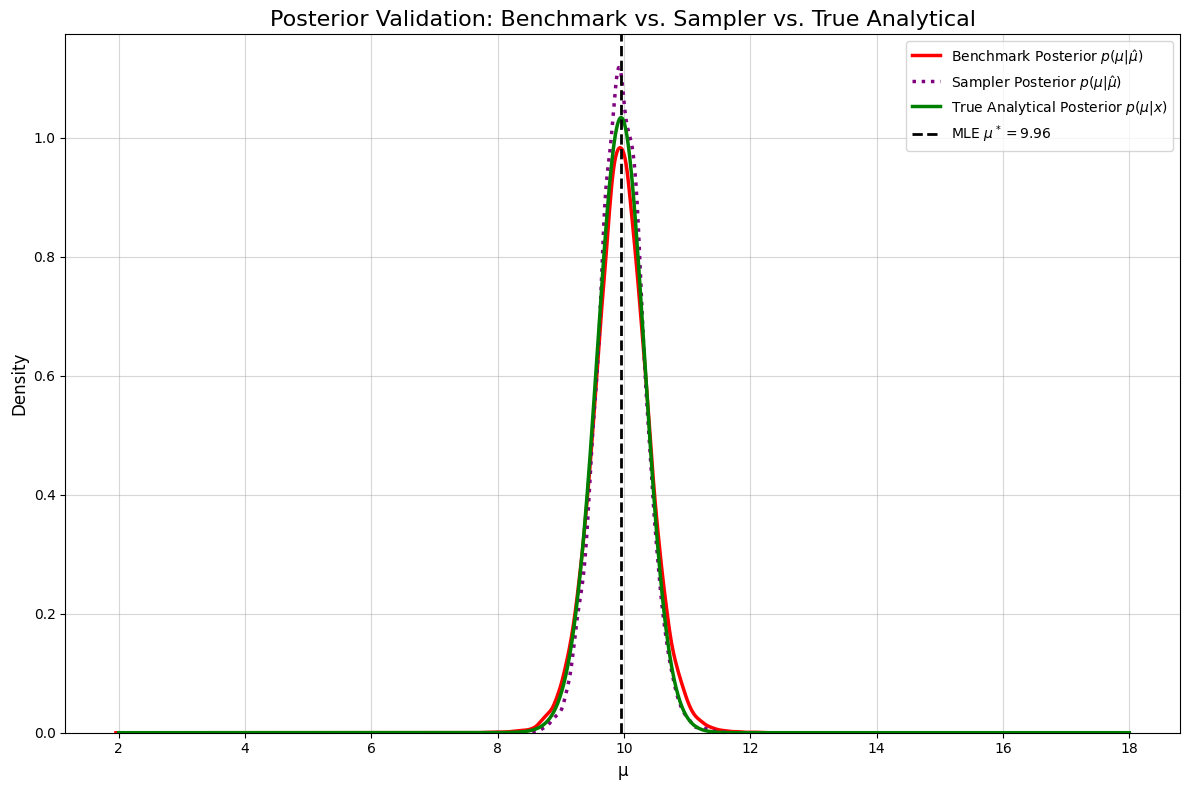

In [14]:

plot_single_run_posterior_validation(x_original=x_original, 
                                     mu_chain_mle=mu_chain_mle, 
                                     kde_0=kde_0, 
                                     sf=sf, 
                                     params=params, 
                                     save_path=None)